In [20]:
df = pd.read_csv('tv_feature_selection.csv')

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from tqdm import tqdm

In [22]:
target = 'popularity'
features = df.columns.drop([target])

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [23]:
def evaluate_model(model, X, y):
    #use of https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.cross_val_score.html
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

In [24]:
results = {}

for name, model in tqdm(models.items()):
    pipeline = Pipeline(steps=[('feature_selection', SelectKBest(f_regression, k=20)),
                               ('model', model)])
    rmse = evaluate_model(pipeline, X_train, y_train)
    results[name] = rmse


100%|██████████| 7/7 [12:52<00:00, 110.35s/it]


In [25]:
# Print results
print("\
Model Comparison Results (RMSE):")
for name, rmse in results.items():
    print(f"{name}: {rmse:.4f}")

# Train the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

best_pipeline = Pipeline(steps=[('feature_selection', SelectKBest(f_regression, k=20)),
                                ('model', best_model)])

best_pipeline.fit(X_train, y_train)

# Make predictions on test set
y_pred = best_pipeline.predict(X_test)

# Calculate final RMSE and R2 score
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"\
Best Model: {best_model_name}")
print(f"Final Test RMSE: {final_rmse:.4f}")
print(f"Final Test R2 Score: {final_r2:.4f}")

# Feature importance (if applicable)
if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
    feature_importance = best_pipeline.named_steps['model'].feature_importances_
    feature_names = best_pipeline.named_steps['feature_selection'].get_feature_names_out(features)
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=False).head(10)
    print("\
Top 10 Important Features:")
    print(importance_df)
elif best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
    coefficients = best_pipeline.named_steps['model'].coef_
    feature_names = best_pipeline.named_steps['feature_selection'].get_feature_names_out(features)
    coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
    coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index).head(10)
    print("\
Top 10 Features by Coefficient Magnitude:")
    print(coef_df)

Model Comparison Results (RMSE):
Linear Regression: 37.9124
Ridge Regression: 37.9124
Lasso Regression: 37.9543
Decision Tree: 48.9434
Random Forest: 37.4109
Gradient Boosting: 37.4923
SVR: 40.5078
Best Model: Random Forest
Final Test RMSE: 36.6232
Final Test R2 Score: 0.0589
Top 10 Important Features:
               feature  importance
1   number_of_episodes    0.321090
0           Unnamed: 0    0.299847
2           vote_count    0.088547
3         vote_average    0.079146
6     episode_run_time    0.054843
19    origin_continent    0.033103
11       genres_Comedy    0.029710
17      genres_UnKnown    0.017103
5                 type    0.012724
8         genres_Drama    0.012103


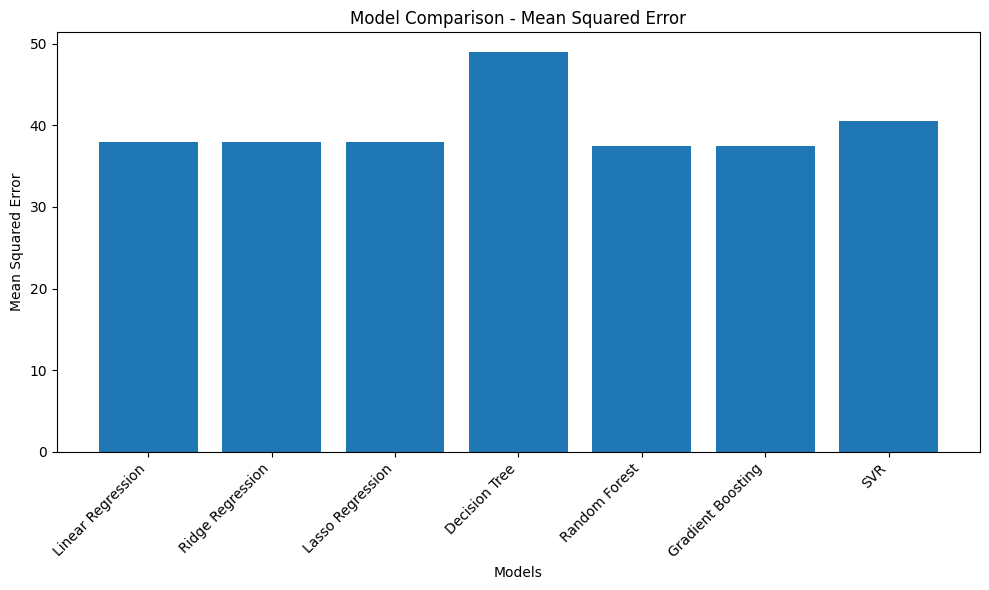

Best performing model: Random Forest
Training the best model...
Making predictions...
Best Model Performance on Test Set:
Mean Squared Error: 1309.5122
R-squared Score: 0.0812


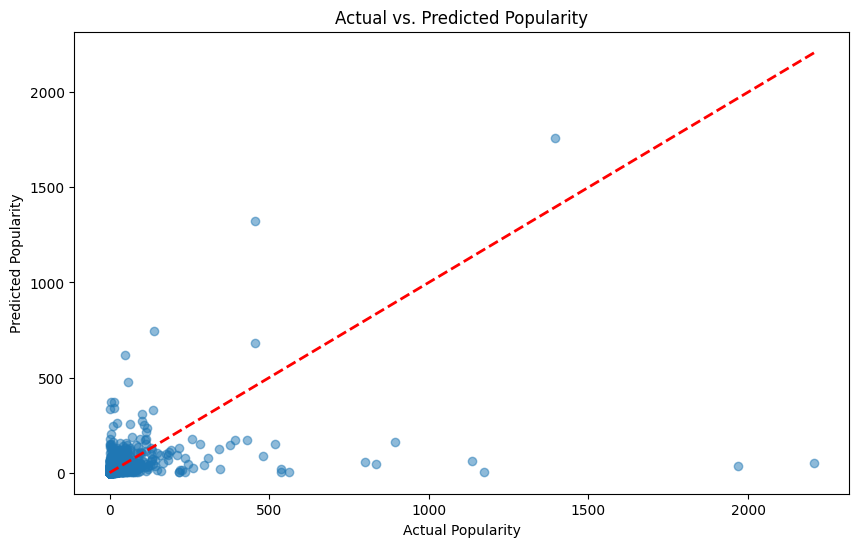

In [27]:
import matplotlib.pyplot as plt

# Visualize results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison - Mean Squared Error')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Train the best model
best_model_name = min(results, key=results.get)
print(f"\
Best performing model: {best_model_name}")

best_pipeline = Pipeline(steps=[('model', models[best_model_name])])

print("Training the best model...")
best_pipeline.fit(X_train, y_train)

# Make predictions on the test set
print("Making predictions...")
y_pred = best_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\
Best Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity')
plt.show()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   7.3s
[CV] END ..max_depth=5, min_samples_split=5, n_estimators=50; total time=  12.1s
[CV] END .max_depth=5, min_samples_split=5, n_estimators=100; total time=  22.9s
[CV] END max_depth=5, min_samples_split=10, n_estimators=100; total time=  30.4s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  20.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  41.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=  45.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=  18.5s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200; total time= 3.5min
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time= 1.7min
[CV] END .max_depth=30, min_samples_split=2, 

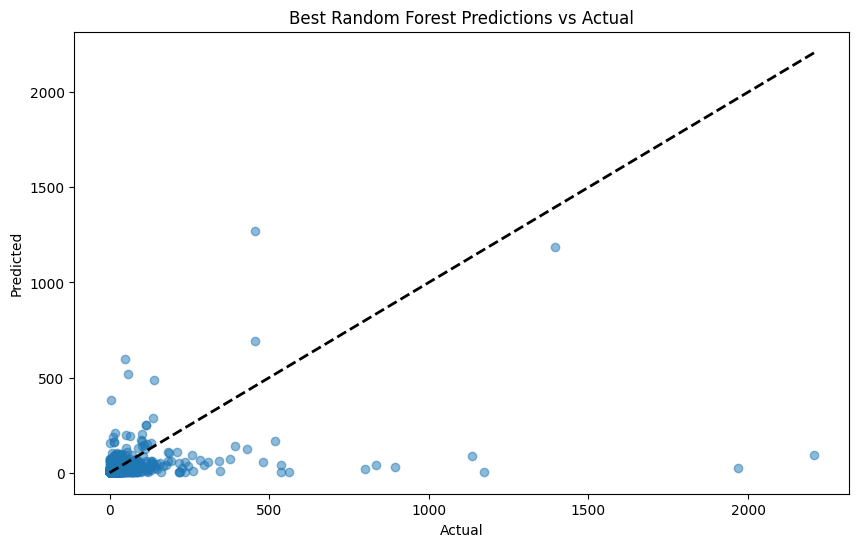

In [29]:
# Hyperparameter tuning for the best model (Random Forest in this case)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print('Best parameters found:', grid_search.best_params_)

# Re-train the best model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)

# Evaluate the best model
best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)
print(f"Best Random Forest - MSE: {best_mse}, R2: {best_r2}")

# Plot the best model predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Best Random Forest Predictions vs Actual')
plt.show()

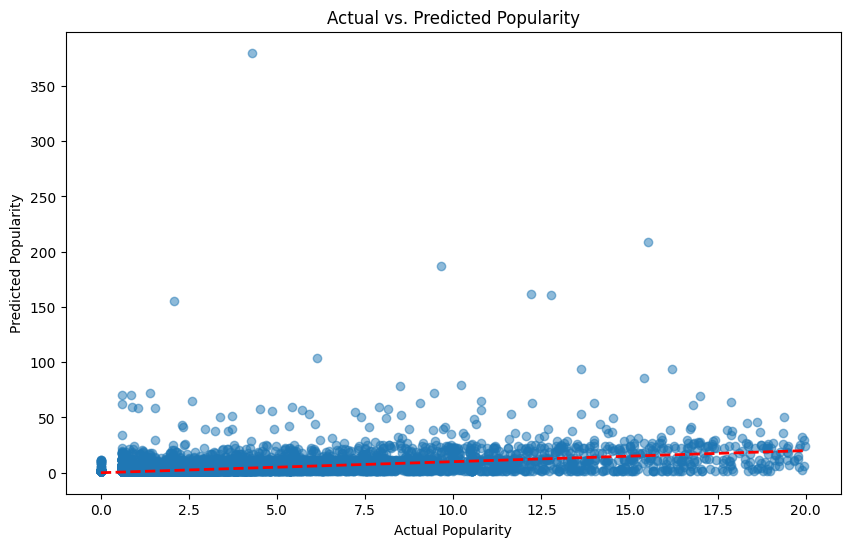

[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time= 2.1min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   7.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=  51.8s
[CV] END max_depth=5, min_samples_split=10, n_estimators=100; total time=  23.8s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  21.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=  43.2s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=  50.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time= 1.8min
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time= 3.4min
[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time= 3.0min
[CV] END .max_depth=30, min_samples_split=5, n_estimators=50; total time=  56.6s
[CV] END max_depth=30, mi

In [31]:
y_test_less = y_test[y_test < 20]
y_pred_less = y_pred_best[y_test < 20]

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_less, y_pred_less, alpha=0.5)
plt.plot([y_test_less.min(), y_test_less.max()], [y_test_less.min(), y_test_less.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity')
plt.show()